# Machine Learning Exercise 6 - Support Vector Machines

This notebook covers a Python-based solution for the sixth programming exercise of the machine learning class on Coursera.  Please refer to the [exercise text](https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex6.pdf) for detailed descriptions and equations.

NOTE: I skipped exercise 5 in the series because it wasn't that interesting.  If you're following along and wondered why we jumped from 4 to 6, that's why.

In this exercise, we'll explore support vector machines (SVMs) using a dataset on student performance. We'll start with SVMs on some simple 2D data sets to understand how they work.  Then we'll do some pre-processing work on a set of raw emails and build a classifier on the processed emails using a SVM to determine if they are spam or not.

The first thing we're going to do is look at a simple 2-dimensional data set and see how a linear SVM works on the data set for varying values of C (similar to the regularization term in linear/logistic regression).  Let's load the data.

In [339]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split
%matplotlib inline

data = pd.read_csv('Student_Performance.csv')
data

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Sample_Question_Papers_Practiced,Performance_Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
995,8,66,No,5,2,60.0
996,1,56,No,4,1,29.0
997,9,72,No,9,5,68.0
998,7,70,Yes,9,3,63.0


In [340]:
# Преобразование Performance_Index в категории
quantiles = data['Performance_Index'].quantile([0.33, 0.66])
low_threshold = quantiles[0.33]
high_threshold = quantiles[0.66]

In [341]:
def categorize_performance(performance):
    if performance < low_threshold:
        return 'low'
    elif performance > high_threshold:
        return 'high'
    else:
        return 'medium'

In [342]:

label_encoder = LabelEncoder()
data['Extracurricular_Activities_Encoded'] = label_encoder.fit_transform(data['Extracurricular_Activities'])

In [343]:
data['Performance_Category'] = data['Performance_Index'].apply(categorize_performance)

In [344]:
# Выбор признаков для модели
X = data[['Hours_Studied', 'Previous_Scores', 'Sleep_Hours', 'Sample_Question_Papers_Practiced', 'Extracurricular_Activities_Encoded']]
y = label_encoder.fit_transform(data['Performance_Category'])

We'll visualize the data as a scatter plot, highlighting different performance categories of students.

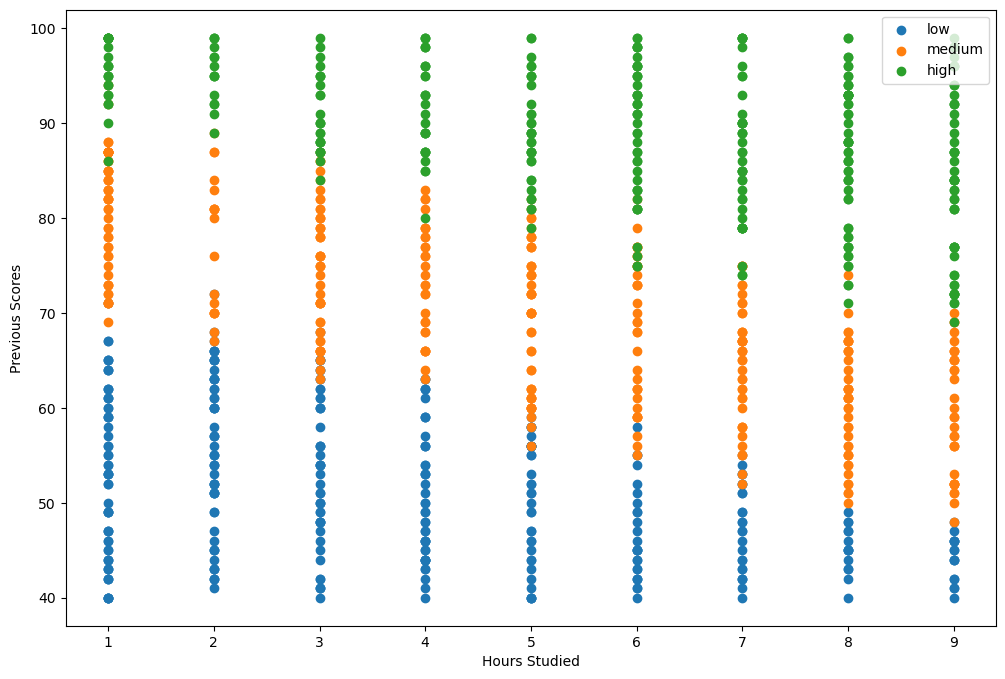

In [345]:
# Выбор признаков для визуализации
data['Performance_Category_Encoded'] = label_encoder.fit_transform(data['Performance_Category'])

# Визуализация данных
fig, ax = plt.subplots(figsize=(12,8))
# Категории для визуализации
categories = ['low', 'medium', 'high']

for category in categories:
    category_data = data[data['Performance_Category'] == category]
    ax.scatter(category_data['Hours_Studied'], category_data['Previous_Scores'], label=category)

ax.legend()
ax.set_xlabel('Hours Studied')
ax.set_ylabel('Previous Scores')
plt.show()


Notice that there is one outlier positive example that sits apart from the others.  The classes are still linearly separable but it's a very tight fit.  We're going to train a linear support vector machine to learn the class boundary.  In this exercise we're not tasked with implementing an SVM from scratch, so I'm going to use the one built into scikit-learn.

In [346]:
from sklearn import svm
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)
svc

LinearSVC(C=1, loss='hinge')

For the first experiment we'll use C=1 and see how it performs.

In [347]:
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=10000)
svc.fit(data[['Hours_Studied', 'Previous_Scores']], data['Performance_Category'])

c:\Users\L\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, loss='hinge', max_iter=10000)

It appears that it mis-classified the outlier.  Let's see what happens with a larger value of C.

In [348]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)
svc2.fit(data[['Hours_Studied', 'Previous_Scores']], data['Performance_Category'])
svc2.score(data[['Hours_Studied', 'Previous_Scores']], data['Performance_Category'])

c:\Users\L\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.604

This time we got a perfect classification of the training data, however by increasing the value of C we've created a decision boundary that is no longer a natural fit for the data.  We can visualize this by looking at the confidence level for each class prediction, which is a function of the point's distance from the hyperplane.

In [349]:
confidences = svc.decision_function(data[['Hours_Studied', 'Previous_Scores']])
data['SVM 1 Confidence Low'] = confidences[:, 0]  # Уверенность для класса 'low'
data['SVM 1 Confidence Medium'] = confidences[:, 1]  # Уверенность для класса 'medium'
data['SVM 1 Confidence High'] = confidences[:, 2]  # Уверенность для класса 'high'

In [350]:
confidences2 = svc2.decision_function(data[['Hours_Studied', 'Previous_Scores']])
data['SVM 2 Confidence Low'] = confidences2[:, 0]
data['SVM 2 Confidence Medium'] = confidences2[:, 1]
data['SVM 2 Confidence High'] = confidences2[:, 2]

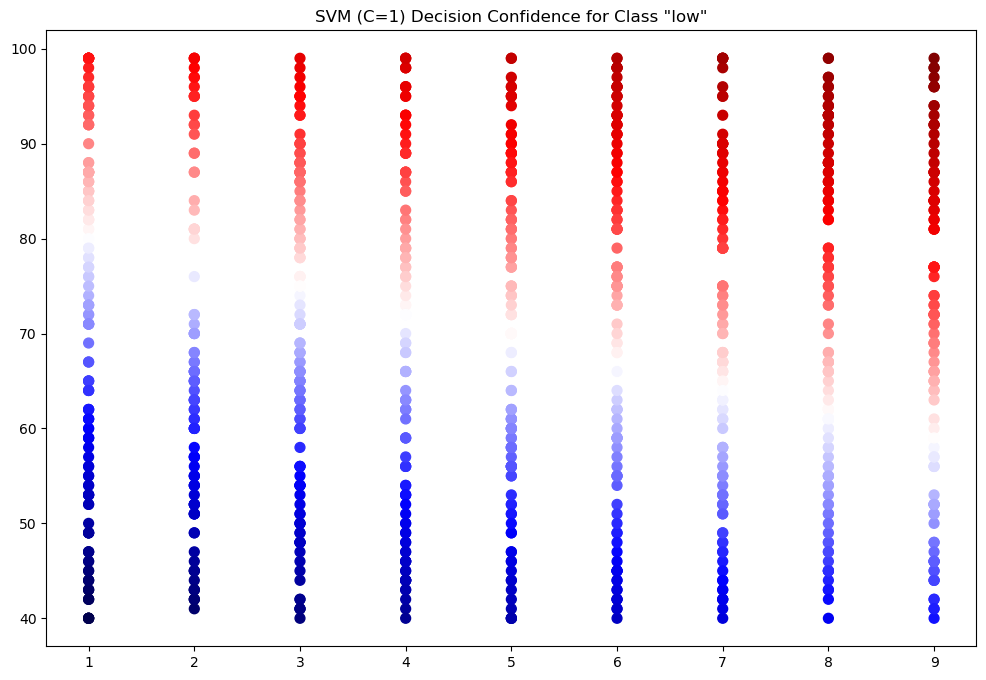

In [351]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['Hours_Studied'], data['Previous_Scores'], s=50, c=data['SVM 1 Confidence Low'], cmap='seismic')
ax.set_title('SVM (C=1) Decision Confidence for Class "low"')
plt.show()

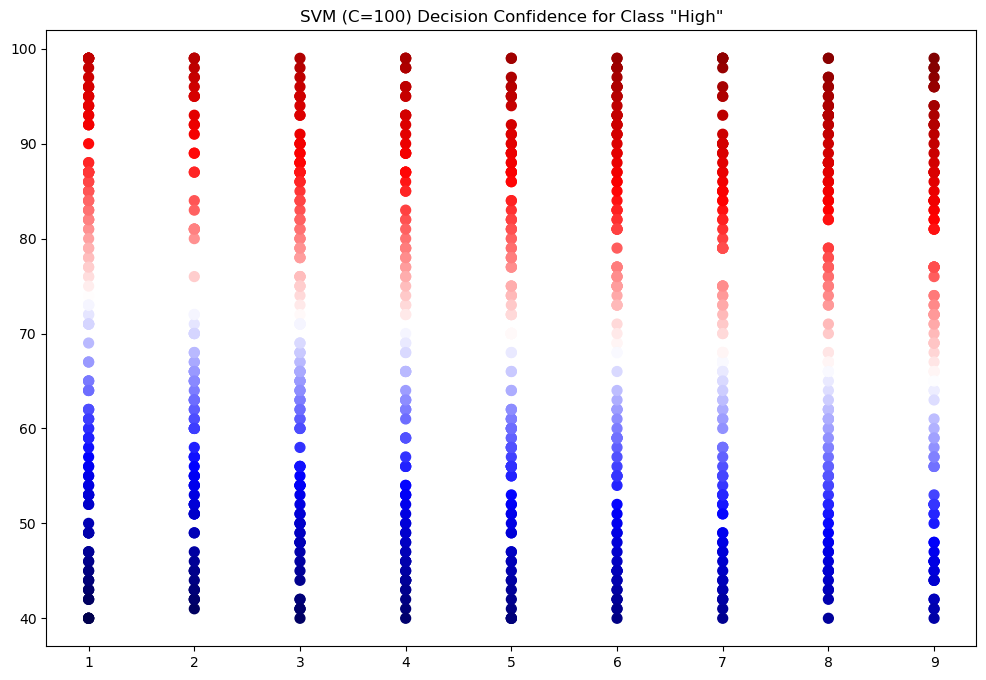

In [352]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['Hours_Studied'], data['Previous_Scores'], s=50, c=data['SVM 2 Confidence High'], cmap='seismic')
ax.set_title('SVM (C=100) Decision Confidence for Class "High"')
plt.show()

The difference is a bit subtle but look at the color of the points near the boundary.  If you're following along in the exercise text, there's a drawing where the decision boundary is shown as a line on the plot which helps make the difference a bit clearer.

We will continue to explore linear SVM with the student performance data to understand the impact of different parameters. We're first tasked with implementing a gaussian kernel function.  Although scikit-learn has a gaussian kernel built in, for transparency we'll implement one from scratch.

In [353]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))

In [354]:
x1 = np.array([1.0, 2.0, 1.0])
x2 = np.array([0.0, 4.0, -1.0])
sigma = 2

gaussian_kernel(x1, x2, sigma)

0.32465246735834974

That result matches the expected value from the exercise.  Next we're going to examine another data set, this time with a non-linear decision boundary.

In [355]:
print(data.columns)


Index(['Hours_Studied', 'Previous_Scores', 'Extracurricular_Activities',
       'Sleep_Hours', 'Sample_Question_Papers_Practiced', 'Performance_Index',
       'Extracurricular_Activities_Encoded', 'Performance_Category',
       'Performance_Category_Encoded', 'SVM 1 Confidence Low',
       'SVM 1 Confidence Medium', 'SVM 1 Confidence High',
       'SVM 2 Confidence Low', 'SVM 2 Confidence Medium',
       'SVM 2 Confidence High'],
      dtype='object')


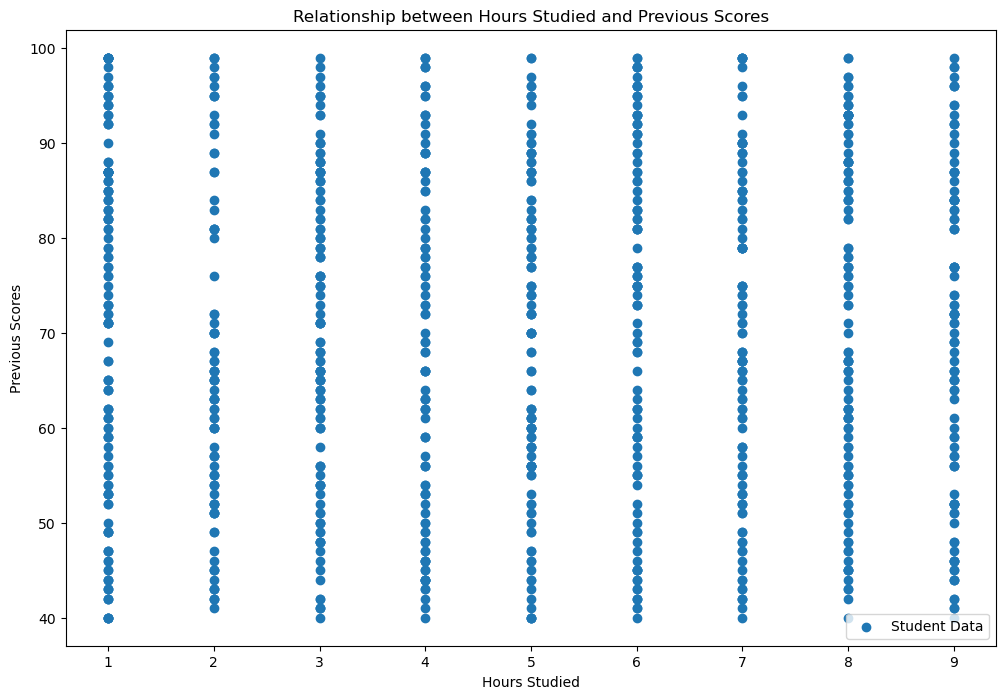

In [356]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(data['Hours_Studied'], data['Previous_Scores'], label='Student Data')
ax.set_xlabel('Hours Studied')
ax.set_ylabel('Previous Scores')
ax.set_title('Relationship between Hours Studied and Previous Scores')
ax.legend()
plt.show()


For this data set we'll build a support vector machine classifier using the built-in RBF kernel and examine its accuracy on the training data.  To visualize the decision boundary, this time we'll shade the points based on the predicted probability that the instance has a negative class label.  We'll see from the result that it gets most of them right.

In [357]:
svc = svm.SVC(C=100, gamma=10, probability=True)
svc

SVC(C=100, gamma=10, probability=True)

In [358]:
svc.fit(data[['Hours_Studied', 'Previous_Scores']], data['Performance_Category_Encoded'])
svc.score(data[['Hours_Studied', 'Previous_Scores']], data['Performance_Category_Encoded'])

0.966

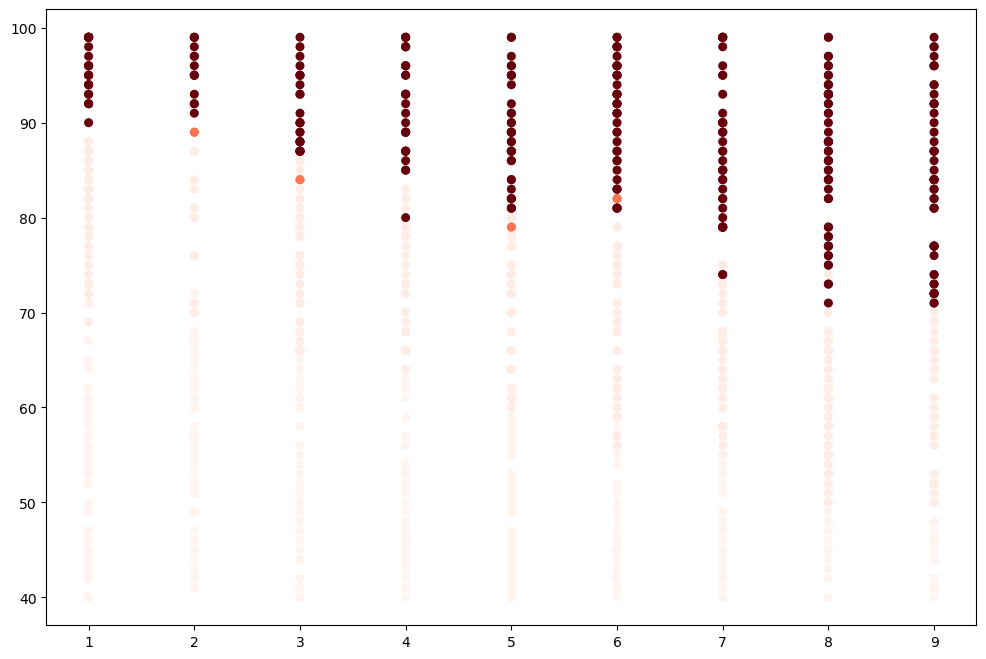

In [359]:
data['Probability'] = svc.predict_proba(data[['Hours_Studied', 'Previous_Scores']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['Hours_Studied'], data['Previous_Scores'], s=30, c=data['Probability'], cmap='Reds')

For the third data set we're given both training and validation sets and tasked with finding optimal hyper-parameters for an SVM model based on validation set performance.  Although we could use scikit-learn's built-in grid search to do this quite easily, in the spirit of following the exercise directions we'll implement a simple grid search from scratch.

In [360]:
from sklearn.model_selection import train_test_split

# Features for prediction
features = ['Hours_Studied', 'Previous_Scores', 'Sleep_Hours', 'Sample_Question_Papers_Practiced', 'Extracurricular_Activities_Encoded']

# Define X and y
X = data[features]
y = data['Performance_Category']


# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% of data is used for validation

# Now you can use X_train, y_train for training and X_val, y_val for validation


In [361]:
C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0
best_params = {'C': None, 'gamma': None}

for C in C_values:
    for gamma in gamma_values:
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X_train, y_train)
        score = svc.score(X_val, y_val)
        
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

print("Best Score:", best_score)
print("Best Parameters:", best_params)


Best Score: 0.955
Best Parameters: {'C': 0.3, 'gamma': 0.1}


Now we'll move on to the second part of the exercise.  In this part our objective is to use SVMs to build a spam filter.  In the exercise text, there's a task involving some text pre-processing to get our data in a format suitable for an SVM to handle.  However, the task is pretty trivial (mapping words to an ID from a dictionary that's provided for the exercise) and the rest of the pre-processing steps such as HTML removal, stemming, normalization etc. are already done.  Rather than reproduce these pre-processing steps, I'm going to skip ahead to the machine learning task which involves building a classifier from pre-processed train and test data sets consisting of spam and non-spam emails transformed to word occurance vectors.

In [362]:
print(data.columns)

Index(['Hours_Studied', 'Previous_Scores', 'Extracurricular_Activities',
       'Sleep_Hours', 'Sample_Question_Papers_Practiced', 'Performance_Index',
       'Extracurricular_Activities_Encoded', 'Performance_Category',
       'Performance_Category_Encoded', 'SVM 1 Confidence Low',
       'SVM 1 Confidence Medium', 'SVM 1 Confidence High',
       'SVM 2 Confidence Low', 'SVM 2 Confidence Medium',
       'SVM 2 Confidence High', 'Probability'],
      dtype='object')


In [363]:
# Загрузка данных
data2 = pd.read_csv('Student_Performance.csv')

label_encoder = LabelEncoder()
data2['Extracurricular_Activities_Encoded'] = label_encoder.fit_transform(data['Extracurricular_Activities'])
data2.info()
# Выбор признаков и целевой переменной
features = ['Hours_Studied', 'Previous_Scores', 'Sleep_Hours', 'Sample_Question_Papers_Practiced']
X = data2[features]
y = data2['Extracurricular_Activities_Encoded']  # Использование Performance_Index в качестве целевой переменной

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Hours_Studied                       1000 non-null   int64  
 1   Previous_Scores                     1000 non-null   int64  
 2   Extracurricular_Activities          1000 non-null   object 
 3   Sleep_Hours                         1000 non-null   int64  
 4   Sample_Question_Papers_Practiced    1000 non-null   int64  
 5   Performance_Index                   1000 non-null   float64
 6   Extracurricular_Activities_Encoded  1000 non-null   int32  
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 50.9+ KB


In [364]:
X.shape, y.shape, X_test.shape, y_test.shape

((1000, 4), (1000,), (200, 4), (200,))

Each document has been converted to a vector with 1,899 dimensions corresponding to the 1,899 words in the vocabulary.  The values are binary, indicating the presence or absence of the word in the document.  At this point, training and evaluation are just a matter of fitting the testing the classifer. 

In [365]:
# Обучение модели SVM
svc = svm.SVC()
svc.fit(X_train, y_train)

# Оценка производительности модели
print('Training accuracy = {0}%'.format(np.round(svc.score(X_train, y_train) * 100, 2)))
print('Test accuracy = {0}%'.format(np.round(svc.score(X_test, y_test) * 100, 2)))

Training accuracy = 52.12%
Test accuracy = 56.0%


In [366]:
svc = svm.SVC()
svc.fit(X, y)
print('Training accuracy = {0}%'.format(np.round(svc.score(X, y) * 100, 2)))

Training accuracy = 51.9%


In [367]:
print('Test accuracy = {0}%'.format(np.round(svc.score(X_test, y_test) * 100, 2)))

Test accuracy = 53.0%


Analyzing the presented accuracy values for the training and test datasets, several important conclusions can be drawn:

Low training and testing accuracy: In both cases, the accuracy on both the training dataset and the test dataset is low (around 52-56%). This indicates that the model does not have sufficient learning ability and cannot generalize the data effectively. Perhaps the model is too simple (not complex enough) for the structure of the data being analyzed.

No overtraining problems: The difference between the accuracy on the training and test datasets is not large, indicating that there is no obvious overtraining. Typically, overtraining manifests itself as high accuracy on the training set and low accuracy on the test set.